Creating Canton of Geneva coverage maps...

Processing Squadrat (Zoom 14) data...
Squadrat - Total in Canton of Geneva: 95, Visited: 45, Coverage: 47.37%

Processing Squadratinho (Zoom 17) data...
Squadratinho - Total in Canton of Geneva: 6099, Visited: 580, Coverage: 9.51%

Creating plots...


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

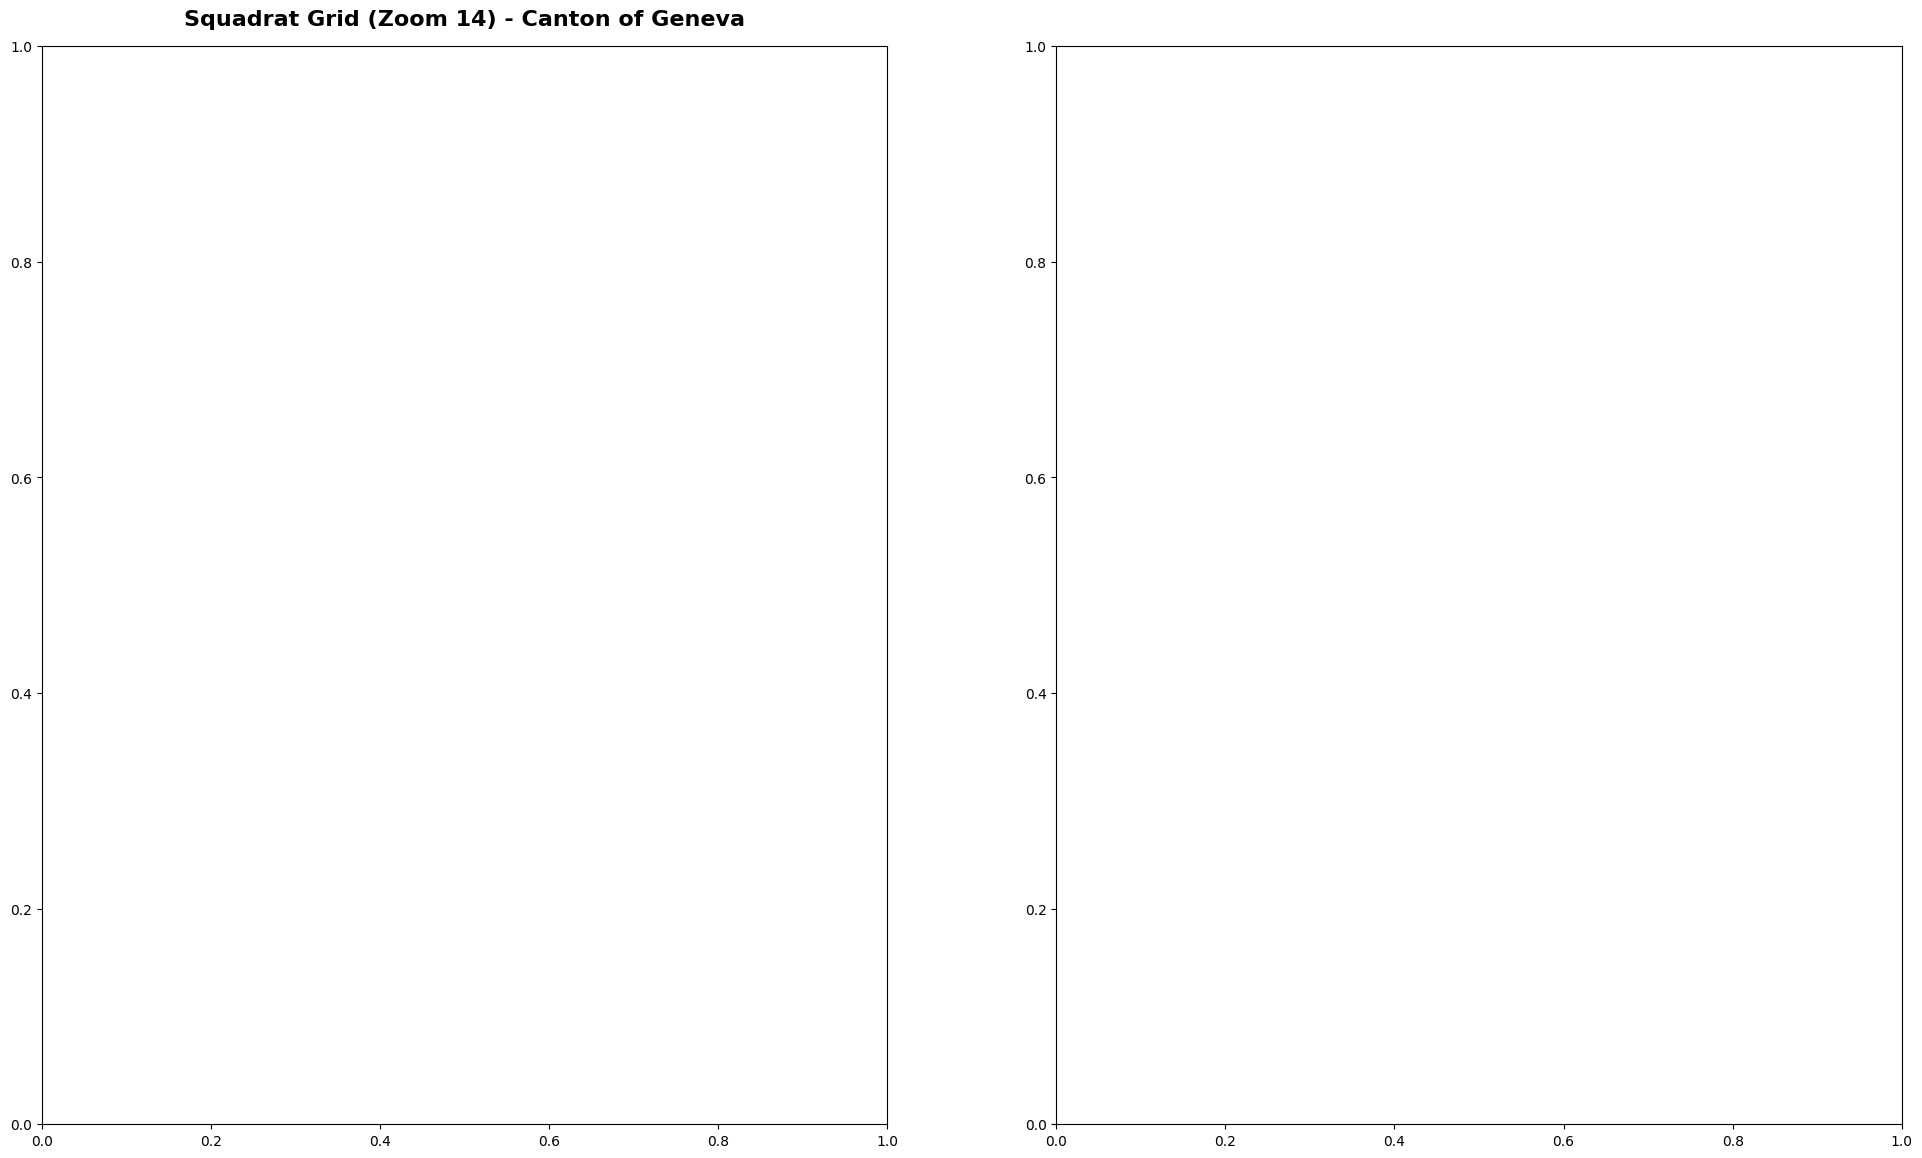

In [ ]:
"""
Create region coverage maps - side by side with proper aspect ratio
Shows all visited tiles in peach, with region visited tiles in orange
Works for any Swiss region (Geneva, Vaud, etc.)
"""

import pandas as pd
import geopandas as gpd
import osmnx as ox
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from shapely.geometry import Point

def tile_to_lon_lat(tile_x, tile_y, zoom):
    """Convert tile coordinates to longitude/latitude (center of tile)"""
    n = 2.0 ** zoom
    lon = (tile_x + 0.5) / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * (tile_y + 0.5) / n)))
    lat = math.degrees(lat_rad)
    return lon, lat

def tile_to_bbox(tile_x, tile_y, zoom):
    """Convert tile to bounding box coordinates"""
    n = 2.0 ** zoom
    west = tile_x / n * 360.0 - 180.0
    east = (tile_x + 1) / n * 360.0 - 180.0
    
    lat_rad_north = math.atan(math.sinh(math.pi * (1 - 2 * tile_y / n)))
    north = math.degrees(lat_rad_north)
    
    lat_rad_south = math.atan(math.sinh(math.pi * (1 - 2 * (tile_y + 1) / n)))
    south = math.degrees(lat_rad_south)
    
    return west, east, south, north

def create_region_maps(region, squadrat_file, squadratinho_file, output_dir='output'):
    """
    Create two side-by-side maps showing region coverage at zoom 14 and 17
    
    Parameters:
    -----------
    region : str
        Name of the region (e.g., 'Geneva', 'Vaud', 'Basel')
    squadrat_file : str
        Path to squadrat grid mask CSV file
    squadratinho_file : str
        Path to squadratinho grid mask CSV file
    output_dir : str
        Output directory for saving the maps
    """
    
    print(f"Creating {region} coverage maps...")
    
    # Download region boundary
    print(f"Downloading {region} boundary from OpenStreetMap...")
    if region == "Canton of Geneva":
        region_gdf = ox.geocode_to_gdf(
            {'state': 'Geneva'}, 
            by_osmid=False,
            which_result=1
        )
    else:
        region_gdf = ox.geocode_to_gdf(f'{region}, Switzerland', which_result=1)
    
    region_geom = region_gdf.geometry.iloc[0]
    
    # Get region bounds for map extent
    bounds = region_geom.bounds  # (minx, miny, maxx, maxy)
    lon_min, lat_min, lon_max, lat_max = bounds
    
    # Calculate center latitude for aspect ratio
    center_lat = (lat_min + lat_max) / 2
    
    # Add some padding
    lon_padding = (lon_max - lon_min) * 0.05
    lat_padding = (lat_max - lat_min) * 0.05
    lon_min -= lon_padding
    lon_max += lon_padding
    lat_min -= lat_padding
    lat_max += lat_padding
    
    # ========== LOAD AND PROCESS SQUADRAT (Zoom 14) ==========
    print("\nProcessing Squadrat (Zoom 14) data...")
    
    df_squadrat = pd.read_csv(squadrat_file)
    
    # Convert tiles to geometry
    tiles_squadrat = []
    for _, row in df_squadrat.iterrows():
        lon, lat = tile_to_lon_lat(row['tile_x'], row['tile_y'], row['zoom'])
        west, east, south, north = tile_to_bbox(row['tile_x'], row['tile_y'], row['zoom'])
        tiles_squadrat.append({
            'lon': lon,
            'lat': lat,
            'west': west,
            'east': east,
            'south': south,
            'north': north,
            'visited': row['inside_polygon'] == 1
        })
    
    # Create GeoDataFrame to check which tiles are in region
    gdf_squadrat = gpd.GeoDataFrame(
        tiles_squadrat,
        geometry=[Point(t['lon'], t['lat']) for t in tiles_squadrat],
        crs='EPSG:4326'
    )
    gdf_squadrat = gdf_squadrat.to_crs(region_gdf.crs)
    gdf_squadrat['in_region'] = gdf_squadrat.within(region_geom)
    gdf_squadrat = gdf_squadrat.to_crs('EPSG:4326')
    
    # Calculate statistics
    tiles_in_region = gdf_squadrat[gdf_squadrat['in_region']]
    total_tiles_region = len(tiles_in_region)
    visited_tiles_region = (tiles_in_region['visited']).sum()
    coverage_squadrat = (visited_tiles_region / total_tiles_region * 100) if total_tiles_region > 0 else 0
    
    print(f"Squadrat - Total in {region}: {total_tiles_region}, Visited: {visited_tiles_region}, Coverage: {coverage_squadrat:.2f}%")
    
    # ========== LOAD AND PROCESS SQUADRATINHO (Zoom 17) ==========
    print("\nProcessing Squadratinho (Zoom 17) data...")
    
    df_squadratinho = pd.read_csv(squadratinho_file)
    
    # Convert tiles to geometry
    tiles_squadratinho = []
    for _, row in df_squadratinho.iterrows():
        lon, lat = tile_to_lon_lat(row['tile_x'], row['tile_y'], row['zoom'])
        west, east, south, north = tile_to_bbox(row['tile_x'], row['tile_y'], row['zoom'])
        tiles_squadratinho.append({
            'lon': lon,
            'lat': lat,
            'west': west,
            'east': east,
            'south': south,
            'north': north,
            'visited': row['inside_polygon'] == 1
        })
    
    # Create GeoDataFrame
    gdf_squadratinho = gpd.GeoDataFrame(
        tiles_squadratinho,
        geometry=[Point(t['lon'], t['lat']) for t in tiles_squadratinho],
        crs='EPSG:4326'
    )
    gdf_squadratinho = gdf_squadratinho.to_crs(region_gdf.crs)
    gdf_squadratinho['in_region'] = gdf_squadratinho.within(region_geom)
    gdf_squadratinho = gdf_squadratinho.to_crs('EPSG:4326')
    
    # Calculate statistics
    tiles_in_region = gdf_squadratinho[gdf_squadratinho['in_region']]
    total_tiles_region = len(tiles_in_region)
    visited_tiles_region = (tiles_in_region['visited']).sum()
    coverage_squadratinho = (visited_tiles_region / total_tiles_region * 100) if total_tiles_region > 0 else 0
    
    print(f"Squadratinho - Total in {region}: {total_tiles_region}, Visited: {visited_tiles_region}, Coverage: {coverage_squadratinho:.2f}%")
    
    # ========== CREATE SIDE-BY-SIDE PLOTS ==========
    print("\nCreating plots...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 14))
    
    # ========== SQUADRAT PLOT (LEFT) ==========
    ax1.set_title(f'Squadrat Grid (Zoom 14) - {region}', fontsize=16, fontweight='bold', pad=15)
    
    # Plot tiles - Order matters: unvisited first, then visited (peach), then visited in region (orange)
    for idx, row in gdf_squadrat.iterrows():
        west, east, south, north = row['west'], row['east'], row['south'], row['north']
        
        # Determine color and style
        if not row['visited']:
            # Unvisited tiles - white
            facecolor = 'white'
            edgecolor = '#5B4B8A'
            alpha = 0.3
            linewidth = 1.0
        elif row['visited'] and row['in_region']:
            # Visited AND in region - orange
            facecolor = 'tab:orange'
            edgecolor = '#5B4B8A'
            alpha = 0.8
            linewidth = 2.5
        else:
            # Visited but NOT in region - peach
            facecolor = '#FFD9B3'
            edgecolor = '#5B4B8A'
            alpha = 0.7
            linewidth = 2.0
        
        rect = patches.Rectangle((west, south), east - west, north - south,
                                linewidth=linewidth, edgecolor=edgecolor,
                                facecolor=facecolor, alpha=alpha)
        ax1.add_patch(rect)
    
    # Plot region boundary in bold black
    if region_geom.geom_type == 'MultiPolygon':
        for geom in region_geom.geoms:
            region_coords = list(geom.exterior.coords)
            xy = [(lon, lat) for lon, lat in region_coords]
            poly = Polygon(xy, linewidth=3, edgecolor='black', facecolor='none', alpha=1.0, zorder=10)
            ax1.add_patch(poly)
    else:
        region_coords = list(region_geom.exterior.coords)
        xy = [(lon, lat) for lon, lat in region_coords]
        poly = Polygon(xy, linewidth=3, edgecolor='black', facecolor='none', alpha=1.0, zorder=10)
        ax1.add_patch(poly)
        
    # Add coverage text
    tiles_in_region_squadrat = gdf_squadrat[gdf_squadrat['in_region']]
    visited_in_region_squadrat = (tiles_in_region_squadrat['visited']).sum()
    ax1.text(0.02, 0.98, f'Coverage: {coverage_squadrat:.2f}%\nTotal tiles in {region}: {len(tiles_in_region_squadrat):,}\nVisited in {region}: {visited_in_region_squadrat:,}',
            transform=ax1.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax1.set_xlim([lon_min, lon_max])
    ax1.set_ylim([lat_min, lat_max])
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True, alpha=0.2, linestyle='--', color='gray')
    ax1.set_aspect(1 / np.cos(np.radians(center_lat)))
    
    # ========== SQUADRATINHO PLOT (RIGHT) ==========
    ax2.set_title(f'Squadratinho Grid (Zoom 17) - {region}', fontsize=16, fontweight='bold', pad=15)
    
    # Plot tiles
    for idx, row in gdf_squadratinho.iterrows():
        west, east, south, north = row['west'], row['east'], row['south'], row['north']
        
        # Determine color and style
        if not row['visited']:
            # Unvisited tiles - white
            facecolor = 'white'
            edgecolor = '#5B4B8A'
            alpha = 0.3
            linewidth = 0.5
        elif row['visited'] and row['in_region']:
            # Visited AND in region - orange
            facecolor = 'tab:orange'
            edgecolor = '#5B4B8A'
            alpha = 0.8
            linewidth = 1.5
        else:
            # Visited but NOT in region - peach
            facecolor = '#FFD9B3'
            edgecolor = '#5B4B8A'
            alpha = 0.7
            linewidth = 1.0
        
        rect = patches.Rectangle((west, south), east - west, north - south,
                                linewidth=linewidth, edgecolor=edgecolor,
                                facecolor=facecolor, alpha=alpha)
        ax2.add_patch(rect)
    
    # Plot region boundary in bold black
    poly = Polygon(xy, linewidth=3, edgecolor='black', facecolor='none', alpha=1.0, zorder=10)
    ax2.add_patch(poly)
    
    # Add coverage text
    tiles_in_region_squadratinho = gdf_squadratinho[gdf_squadratinho['in_region']]
    visited_in_region_squadratinho = (tiles_in_region_squadratinho['visited']).sum()
    ax2.text(0.02, 0.98, f'Coverage: {coverage_squadratinho:.2f}%\nTotal tiles in {region}: {len(tiles_in_region_squadratinho):,}\nVisited in {region}: {visited_in_region_squadratinho:,}',
            transform=ax2.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax2.set_xlim([lon_min, lon_max])
    ax2.set_ylim([lat_min, lat_max])
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)
    ax2.grid(True, alpha=0.2, linestyle='--', color='gray')
    ax2.set_aspect(1 / np.cos(np.radians(center_lat)))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{region}_coverage.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved: {output_dir}/{region}_coverage.png")
    plt.close()
    
    print("\nDone! Map created successfully.")


# Main execution
if __name__ == "__main__":
    
    squadrat_file = 'output/squadrat_grid_mask_Nyon.csv'
    squadratinho_file = 'output/squadratinho_grid_mask_Nyon.csv'
    
    create_region_maps(
        region='Canton of Geneva', # You can also create maps for other regions
        squadrat_file=squadrat_file,
        squadratinho_file=squadratinho_file,
        output_dir='figure'
    )
